<a href="https://colab.research.google.com/github/codemanjaa/644-1_Introduction-Room/blob/master/Mayura_MLR_Demo1_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

#@title Import the required libraries
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing

In [33]:
#@title Load the CSV file
url = 'http://users.jyu.fi/~olkhriye/ties4911/demos/demo1/Automobile_price_data_Raw_set.csv'
column_names = ['make', 'body-style', 'wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg','num-of-cylinders','price']
raw_dataset = pd.read_csv(url, usecols=column_names)
dataset = raw_dataset.copy()

In [34]:
#@title Check the dataset
dataset.head()

,make,body-style,wheel-base,num-of-cylinders,engine-size,horsepower,peak-rpm,highway-mpg,price
0,alfa-romero,convertible,88.6,four,130,111.0,5000.0,27,13495.0
1,alfa-romero,convertible,88.6,four,130,111.0,5000.0,27,16500.0
2,alfa-romero,hatchback,94.5,six,152,154.0,5000.0,26,16500.0
3,audi,sedan,99.8,four,109,102.0,5500.0,30,13950.0
4,audi,sedan,99.4,five,136,115.0,5500.0,22,17450.0


In [35]:
#@title Check for null values
dataset.isnull().sum()

make                4
body-style          1
wheel-base          0
num-of-cylinders    0
engine-size         0
horsepower          2
peak-rpm            2
highway-mpg         0
price               4
dtype: int64

In [68]:
dataset['target'] = dataset['price']
dataset = dataset.drop(columns=['num-of-cylinders','price'])

In [69]:
#@title Remove null values and check the data
dataset = dataset.dropna()
dataset.isnull().sum()

make           0
body-style     0
wheel-base     0
engine-size    0
horsepower     0
peak-rpm       0
highway-mpg    0
target         0
dtype: int64

In [70]:
#@title Splits the dataset into train, validate & test
train, test = train_test_split(dataset, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

124 train examples
31 validation examples
39 test examples


In [71]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [72]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [73]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of engine-size:', train_features[ 'engine-size'])
print('A batch of targets:', label_batch )

Every feature: ['make', 'body-style', 'wheel-base', 'engine-size', 'horsepower', 'peak-rpm', 'highway-mpg']
A batch of engine-size: tf.Tensor([181  90 108 122  98], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([14399.  6229.  7603.  8189.  8358.], shape=(5,), dtype=float64)


In [74]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [75]:
horsepower_col = train_features['horsepower']
layer = get_normalization_layer('horsepower', train_ds)
layer(horsepower_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.2997495 ],
       [-0.9794071 ],
       [-0.84374297],
       [-0.43675074],
       [-0.9251414 ]], dtype=float32)>

In [76]:
peakrpm_col = train_features['peak-rpm']
layer = get_normalization_layer('peak-rpm', train_ds)
layer(peakrpm_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.19045025],
       [ 0.7959835 ],
       [-1.424305  ],
       [-0.21323857],
       [-0.6169274 ]], dtype=float32)>

In [77]:
highwaympg_col = train_features['highway-mpg']
layer = get_normalization_layer('highway-mpg', train_ds)
layer(highwaympg_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.2269338 ],
       [ 1.1159312 ],
       [ 0.09092774],
       [ 0.2373568 ],
       [ 0.5302149 ]], dtype=float32)>

In [78]:
wheelbase_col = train_features['wheel-base']
layer = get_normalization_layer('wheel-base', train_ds)
layer(wheelbase_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.19626833],
       [-0.86256164],
       [-0.92577434],
       [-0.45167172],
       [-0.54649323]], dtype=float32)>

In [79]:
enginesize_col = train_features['engine-size']
layer = get_normalization_layer('engine-size', train_ds)
layer(enginesize_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.2423458 ],
       [-0.87623227],
       [-0.45717284],
       [-0.13123776],
       [-0.6899836 ]], dtype=float32)>

In [80]:
#@title One hot vector encoded Layer - transform the strings to integer values
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [81]:
make_col = train_features['make']
layer = get_category_encoding_layer('make', train_ds, 'string')
layer(make_col)

<tf.Tensor: shape=(5, 23), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [82]:
bodystyle_col = train_features['body-style']
layer = get_category_encoding_layer('body-style', train_ds, 'string')
layer(bodystyle_col)

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [83]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [86]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['wheel-base','engine-size', 'horsepower','peak-rpm','highway-mpg']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [87]:
# Categorical features encoded as string.
categorical_cols = ['make', 'body-style']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [88]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

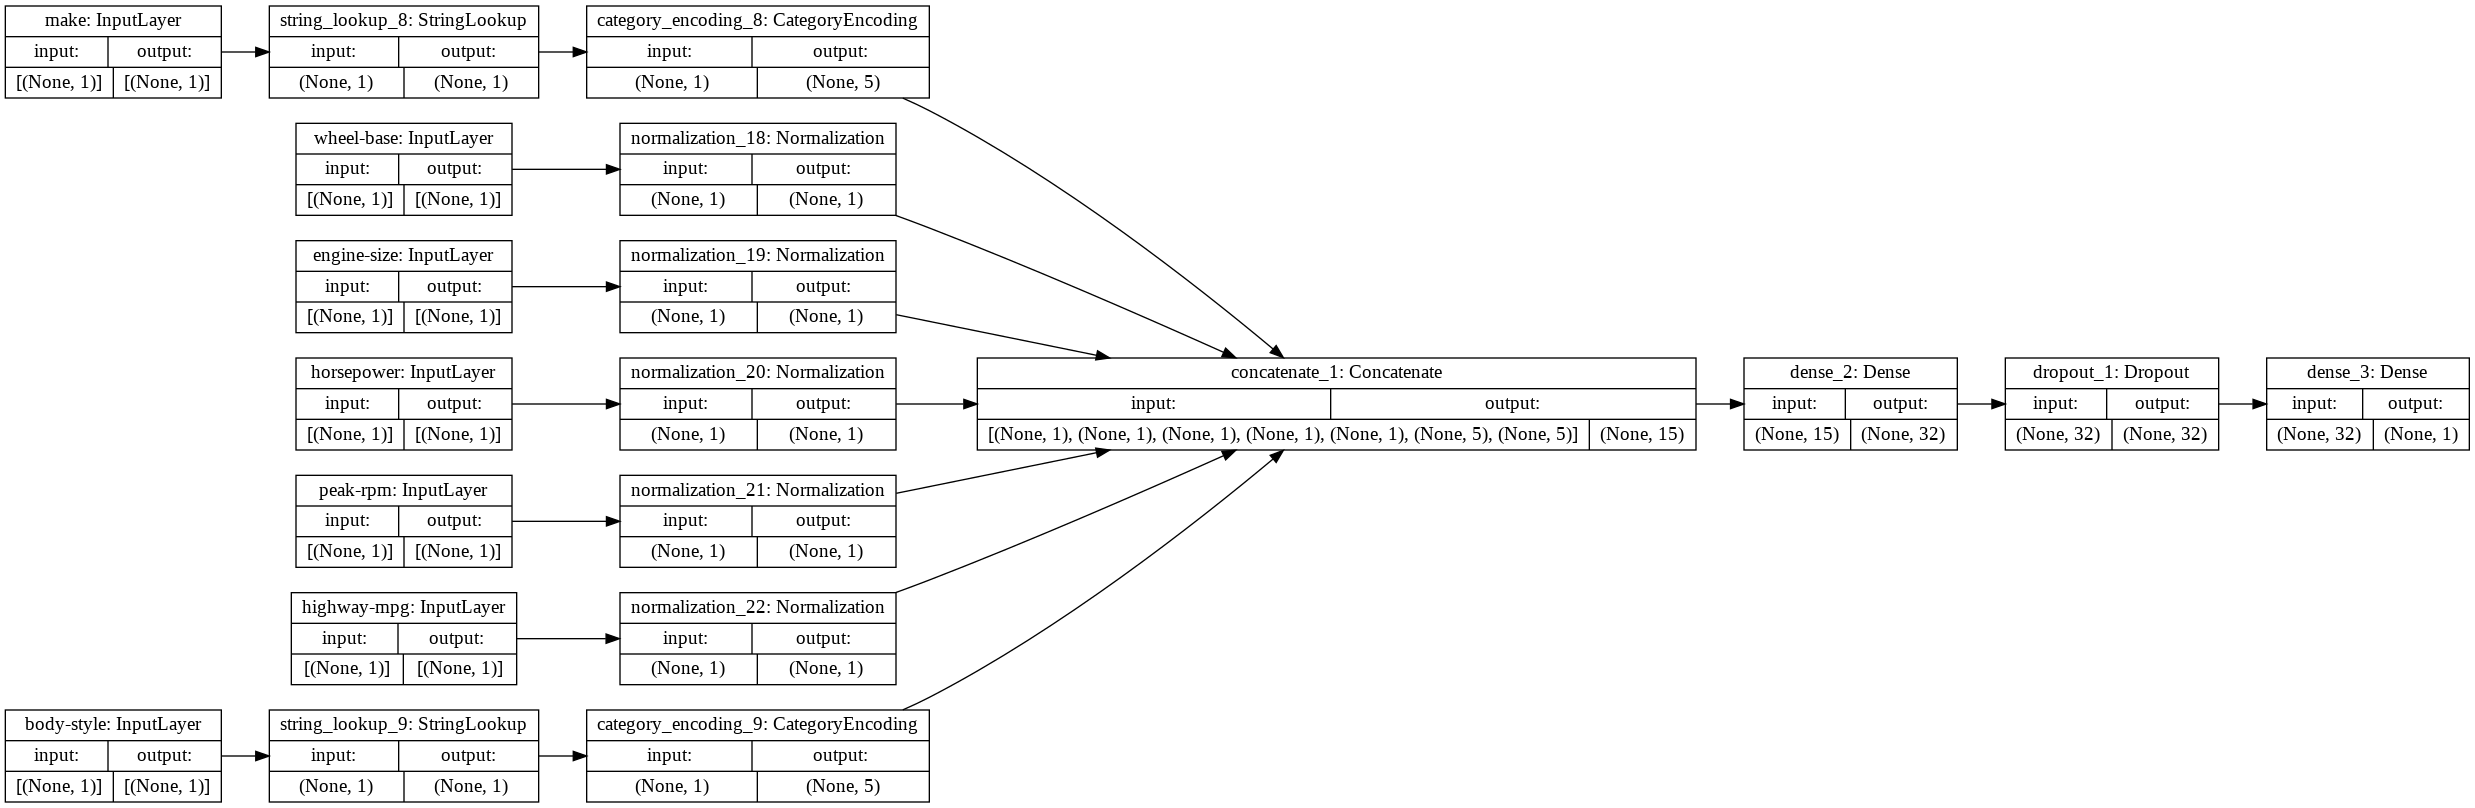

In [89]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [90]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
4/4 [==============================] - 1s 82ms/step - loss: -3954.4780 - accuracy: 0.0000e+00 - val_loss: -5491.6646 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 12ms/step - loss: -7522.8318 - accuracy: 0.0000e+00 - val_loss: -6507.0679 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 12ms/step - loss: -6621.0012 - accuracy: 0.0000e+00 - val_loss: -7526.8003 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: -11853.7934 - accuracy: 0.0000e+00 - val_loss: -8560.4375 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 12ms/step - loss: -9244.9924 - accuracy: 0.0000e+00 - val_loss: -9599.0127 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 12ms/step - loss: -11067.0799 - accuracy: 0.0000e+00 - val_loss: -10653.7285 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 12ms/step - lo

In [91]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 3ms/step - loss: -16420.0801 - accuracy: 0.0000e+00
Accuracy 0.0


In [92]:
model.save('my_auto_classifier')
reloaded_model = tf.keras.models.load_model('my_auto_classifier')

INFO:tensorflow:Assets written to: my_auto_classifier/assets


In [103]:
sample = {
    'make': 'audi',
    'body-style': 'hatchback',
    'wheel-base': 99.5,
    'engine-size': 131,
    'horsepower': 160,
    'peak-rpm': 5500,
    'highway-mpg': 22,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular automobile had a predicted price %.1f  "
     % (100 * prob)
)

This particular automobile had a predicted price 76.8  
